### Variational inference using transport with PyTorch

Mathematical description: Consider the posterior distribution 
$$\pi^y(u) \propto \rho(u)\mathsf{I}(y|u)$$

Approximate $\pi^y(u) \approx q(u)$ by minimizing the reverse KL divergence over a family of distributions $\mathcal{Q}$:
\begin{align*}
\min_{q \in \mathcal{Q}} D_{KL}(q||\pi^y)\\
\end{align*}

Minimizing the KL is equivalent to
\begin{align*}
&\arg\min_q D_{KL}(q||\pi^y) = \arg\min_q \mathbb{E}_{u \sim q}[\log q(u) - \log \rho(u) - \log\mathsf{I}(y|u)]
\end{align*}


In [73]:
import torch
from torch import nn
import numpy as np
from torch import distributions
import matplotlib.pyplot as plt

## Posterior for Biochemical Oxygen Demand Model

**Parameters**:
$$A \sim U(0.4,1.2), \text{ and  }  B \sim U(0.01,0.31)$$

Transform uniform variables to $\R^2$ using uniform CDF: $\Phi : \R \rightarrow [0,1]$
\begin{align*}
A &= 0.4 + 0.4\Phi(u_1)\\
B &= 0.01 + 0.15\Phi(u_2)
\end{align*}

**Prior**:
$$u \sim \mathcal{N}(0,I_2)$$

**Forward Model**: 
$$\mathfrak{B}(t;u) = A(1−\exp(−Bt))$$
$$G(u) = [\mathfrak{B}(1;u),\mathfrak{B}(2;u),\mathfrak{B}(3;u),\mathfrak{B}(4;u),\mathfrak{B}(5;u)]$$
$$y = G(u) + \eta, \qquad \eta \sim \mathcal{N}(0, \Gamma), \Gamma = 10^{-3} I_5$$

Our goal will be to sample $u \in \mathbb{R}^2$ conditioned on a data measurement $y \in \mathbb{R}^5$.

In [74]:
class posterior():
    def __init__(self, y=None):
        self.dim = 2
        self.obs_time = torch.tensor([1,2,3,4,5])
        self.gamma_var = torch.tensor(1e-3)
        self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
        self.lik = distributions.MultivariateNormal(torch.zeros(5), torch.eye(5)*self.gamma_var)
        self.y = y #fixed data
        
    def forward_model(self, x):
        # compute model parameters A and B
        A = 0.4 + 0.4*(1 + torch.erf(x[:,0]/torch.sqrt(torch.tensor(2.))))
        B = 0.01 + 0.15*(1 + torch.erf(x[:,1]/torch.sqrt(torch.tensor(2.))))
        # evaluate exponential model
        return (A * (1 - torch.exp(-1*B*self.obs_time[:,None]))).T
        
    def sample_data(self, x):
        # evaluate model
        Gx = self.forward_model(x)
        # evaluate noise
        noise = self.lik.sample((x.shape[0],))
        return Gx + noise
    
    def log_likelihood(self, x):
        return self.lik.log_prob(self.y - self.forward_model(x))

    def log_prior(self, x):
        return self.prior.log_prob(x)
    
    def log_prob(self, x):
        return self.log_likelihood(x) + self.log_prior(x)

# test posterior evaluations
y = torch.tensor([0.1615, 0.1868, 0.3949, 0.3728, 0.4177])
pi = posterior(y=y)

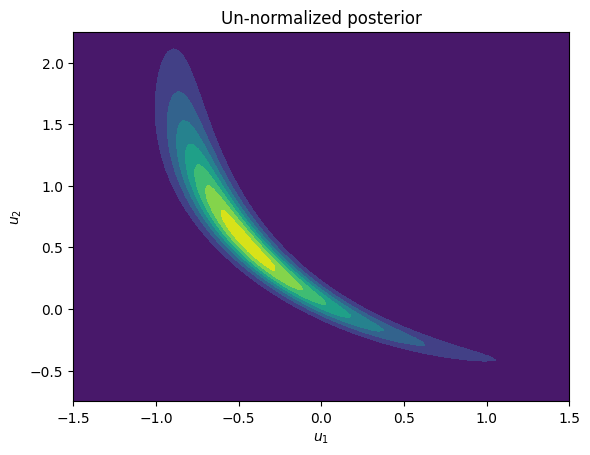

In [75]:
# define domain
domain_x1 = [-1.5,1.5]
domain_x2 = [-0.75,2.25]

# grid of the spatial domain (for plotting)
x1 = torch.linspace(domain_x1[0],domain_x1[1], 100)
x2 = torch.linspace(domain_x2[0],domain_x2[1], 100)
xg = torch.meshgrid(x1, x2)
xx = torch.cat((xg[0].reshape(-1, 1), xg[1].reshape(-1, 1)), 1)

plt.figure()
plt.contourf(xg[0],xg[1],torch.exp(pi.log_prob(xx).detach().reshape(len(x1), len(x2))))
plt.xlim(domain_x1)
plt.ylim(domain_x2)
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.title('Un-normalized posterior')
plt.show()

## Define model

Here we will use Gaussian-based variational inference for the approximate density
\begin{equation*}
    q = \mathcal{N}(m, \Sigma),
\end{equation*}
where $m \in \R^2$ is the mean parameter and $\Sigma \in \R^{2 \times 2}$ is the covariance

1. **Mean-Field family**:
$$\Sigma = \begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \end{bmatrix}$$
1. **General Gaussian family**:
$$\Sigma = L L^T, \qquad L \in \R^{2 \times 2}$$


In [83]:
class MeanFieldGaussianApproximation(nn.Module):
    def __init__(self, pi):
        super(MeanFieldGaussianApproximation, self).__init__()
        self.pi  = pi
        self.mean   = torch.nn.Parameter(torch.zeros(pi.dim,))
        self.logstd = torch.nn.Parameter(torch.zeros(pi.dim,))
        self.ref    = distributions.MultivariateNormal(torch.zeros(pi.dim), torch.eye(pi.dim))

    def entropy(self):
        return -torch.sum(self.logstd)

    def neg_log_prob(self, x):
        return self.entropy() - self.pi.log_prob(x)

    def approximate_log_prob(self, x):
        z = (x - self.mean) / torch.exp(self.logstd)
        return self.ref.log_prob(z) - torch.sum(self.logstd)

    def sample(self, batchSize): 
        z = self.ref.sample((batchSize,))
        x = torch.exp(self.logstd) * z + self.mean
        return x
    
class FullGaussianApproximation(nn.Module):
    def __init__(self, pi):
        super(FullGaussianApproximation, self).__init__()
        self.pi  = pi
        self.mean   = torch.nn.Parameter(torch.zeros(pi.dim,))
        self.chol   = torch.nn.Parameter(torch.eye(pi.dim))
        self.ref    = distributions.MultivariateNormal(torch.zeros(pi.dim), torch.eye(pi.dim))

    def cov(self):
        return torch.matmul(self.chol, self.chol.T)

    def entropy(self):
        return -0.5*torch.logdet(self.cov())

    def neg_log_prob(self, x):
        return self.entropy() - self.pi.log_prob(x)

    def approximate_log_prob(self, x):
        approx = distributions.MultivariateNormal(self.mean, self.cov())
        return approx.log_prob(x)

    def sample(self, batchSize): 
        z = self.ref.sample((batchSize,))
        x = torch.matmul(self.chol, z.T).T + self.mean
        return x

## Train model

  step     J_NF   


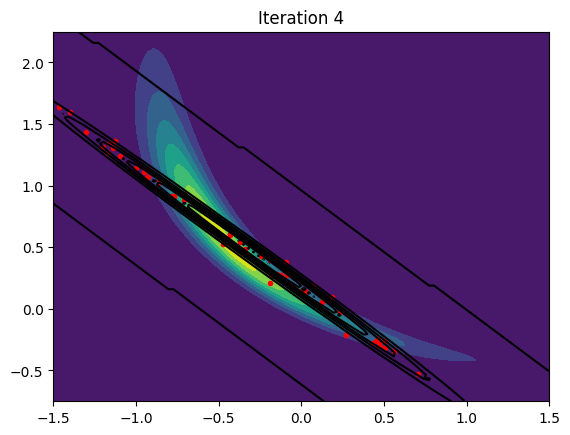

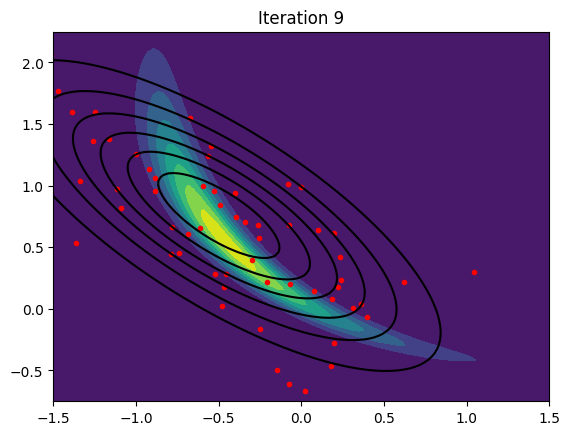

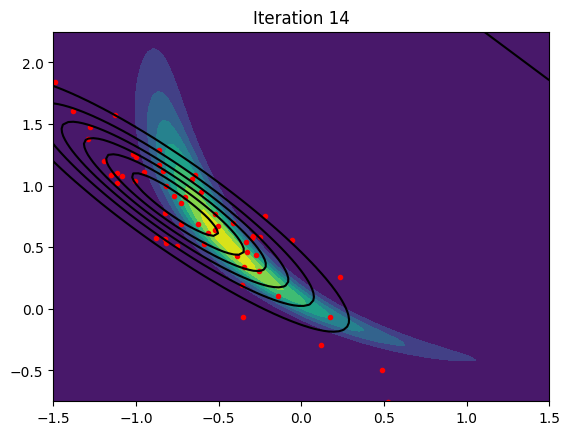

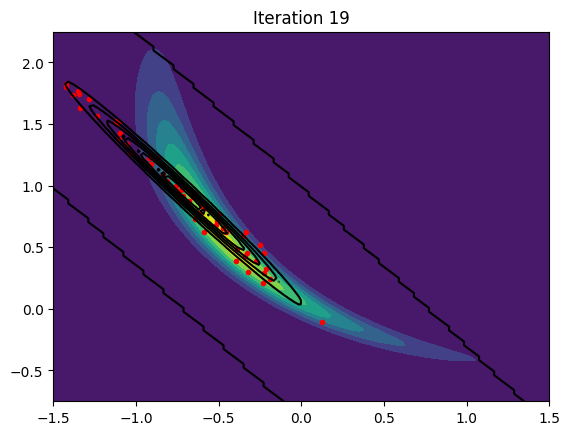

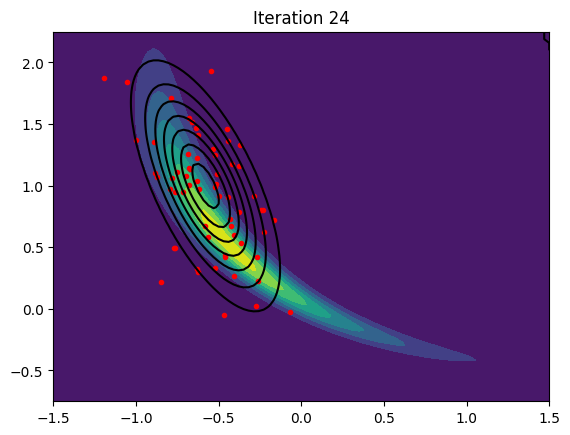

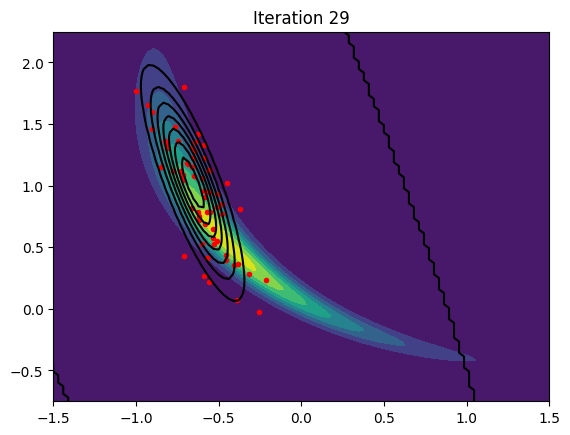

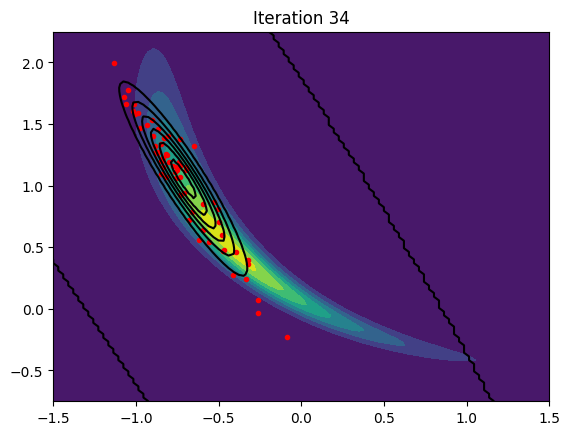

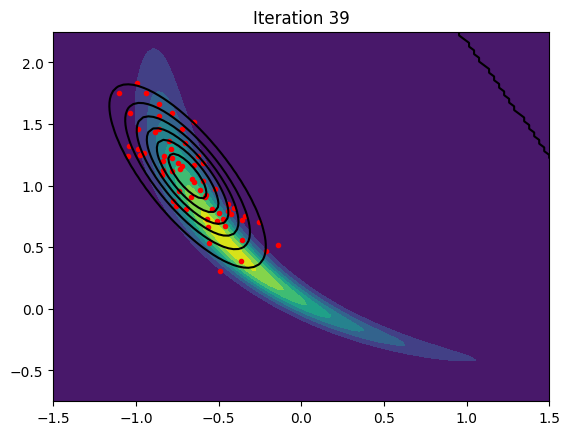

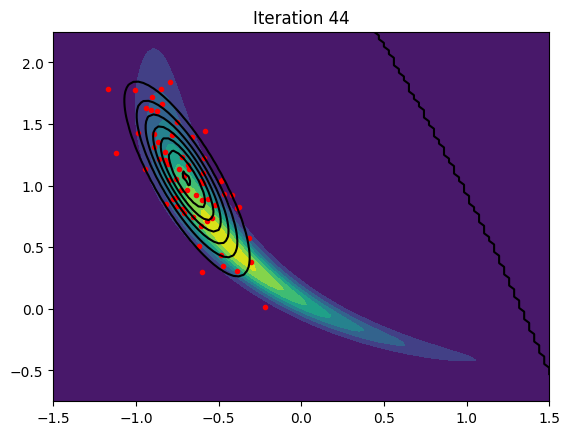

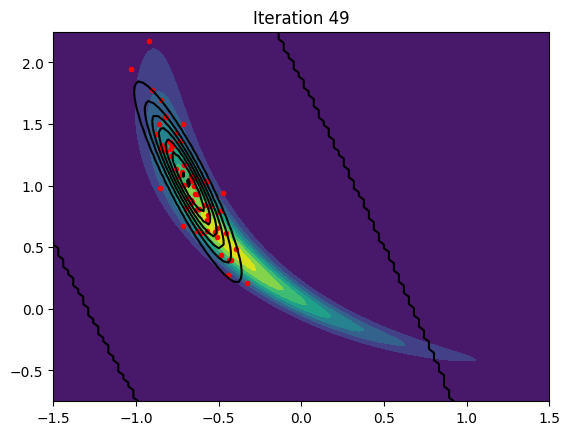

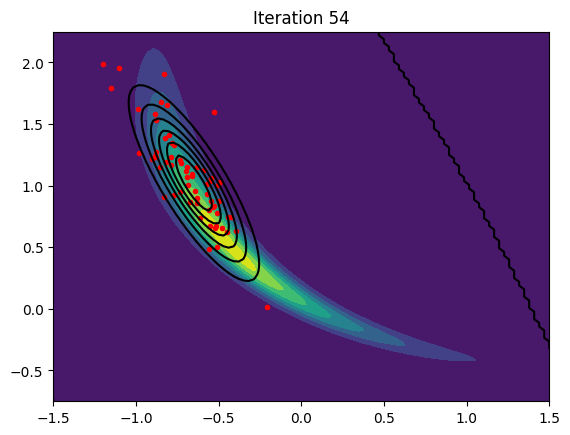

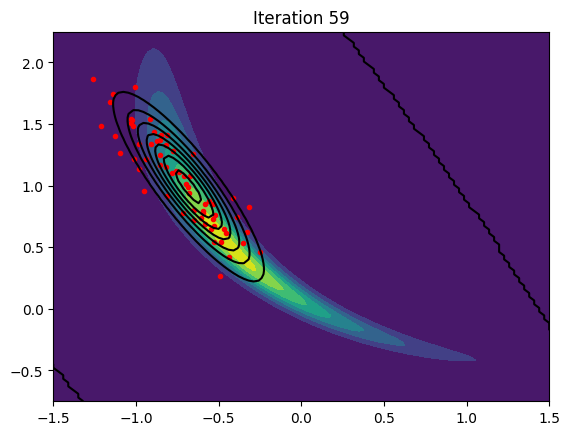

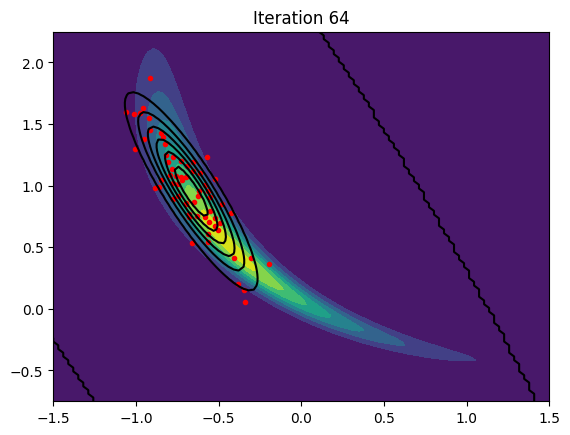

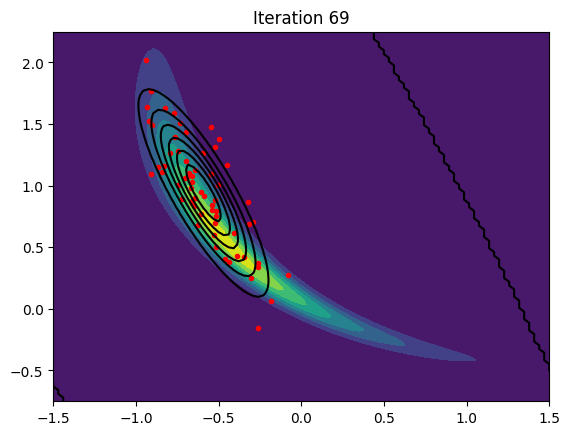

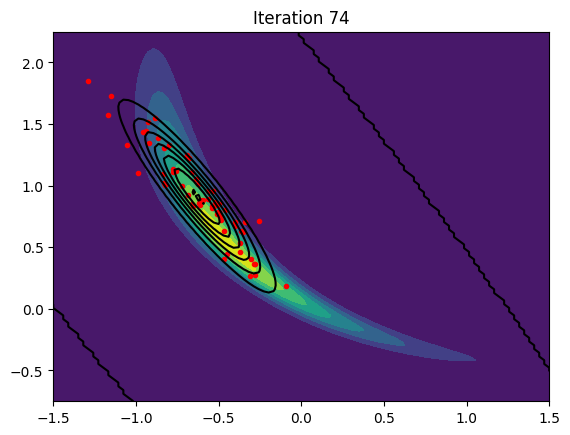

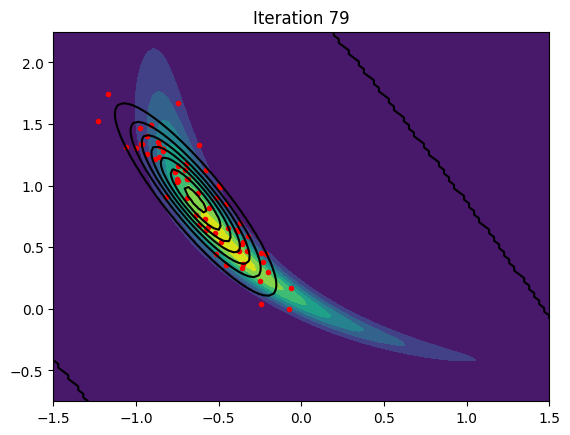

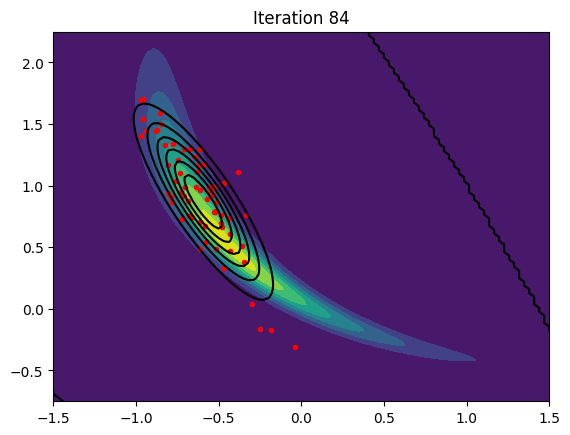

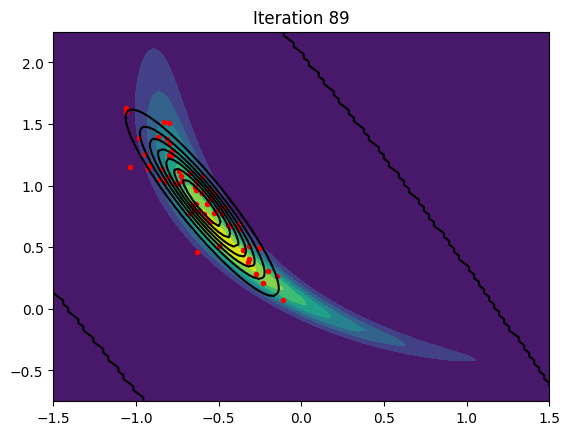

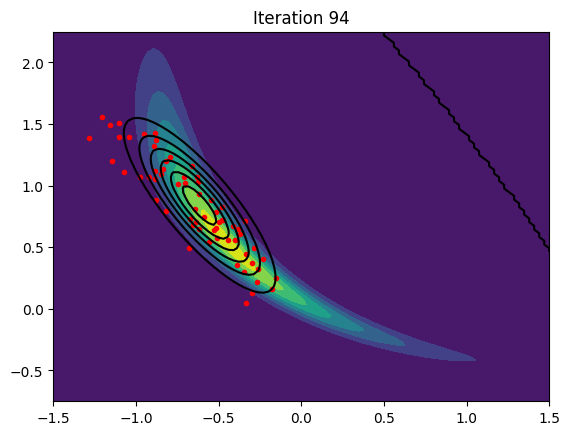

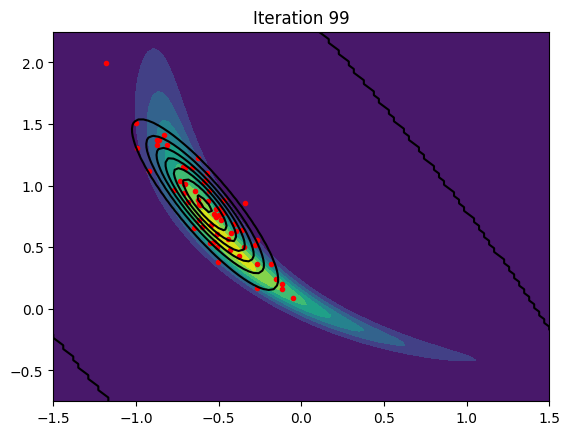

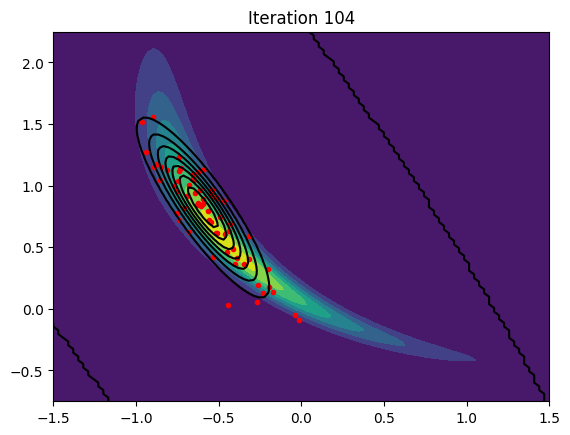

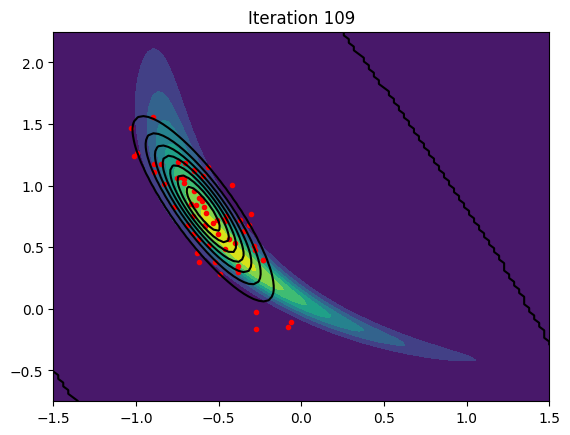

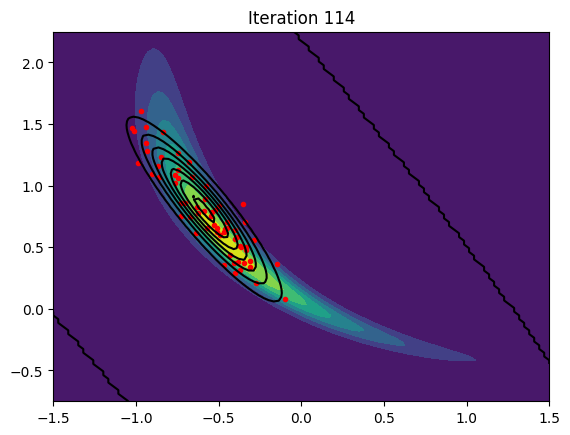

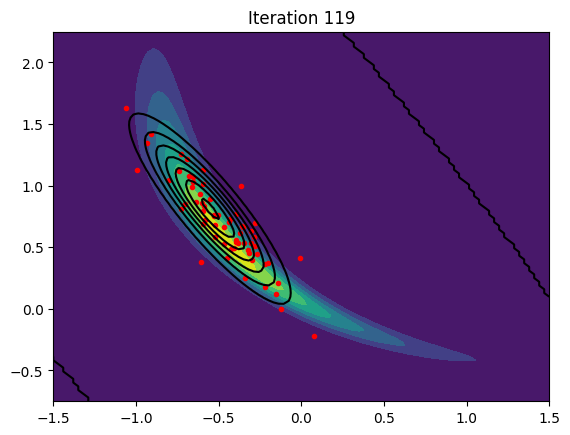

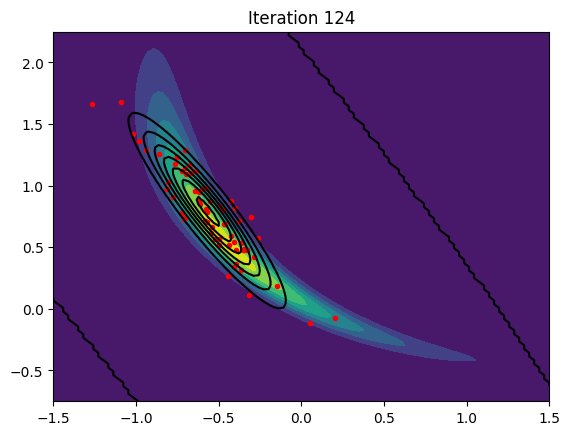

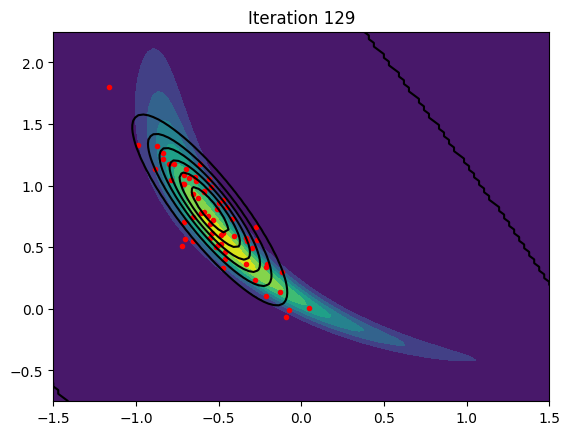

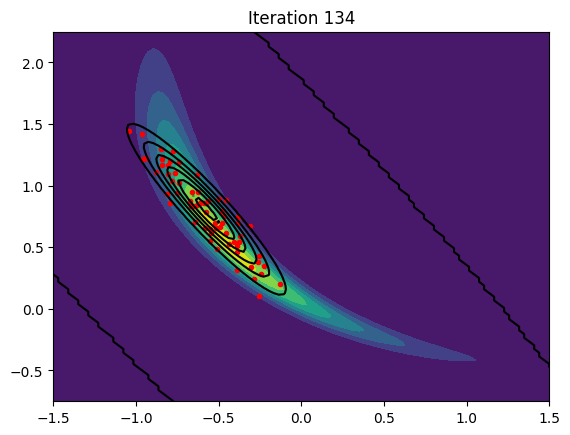

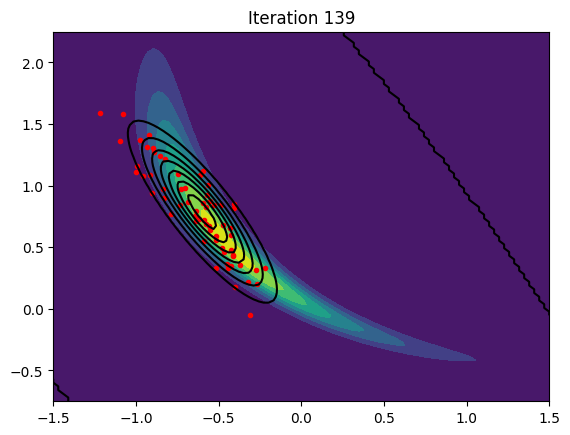

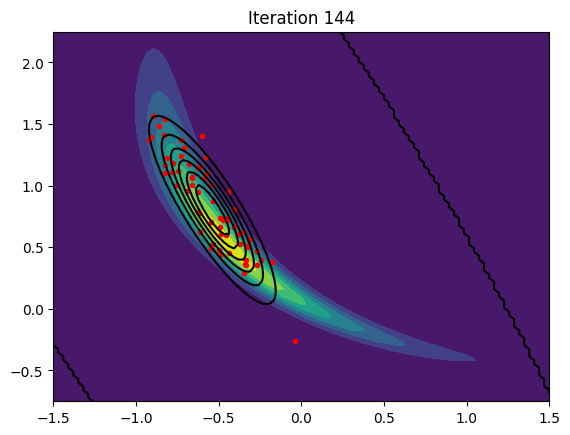

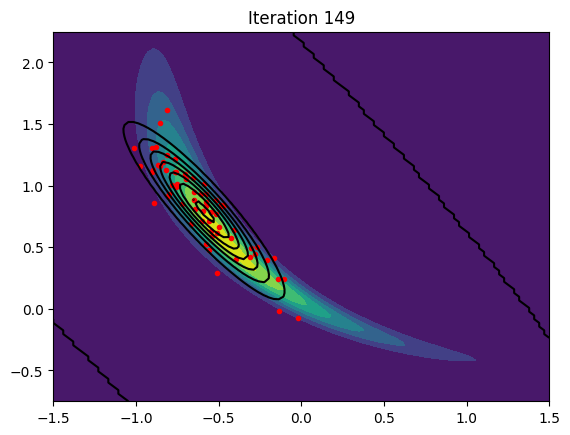

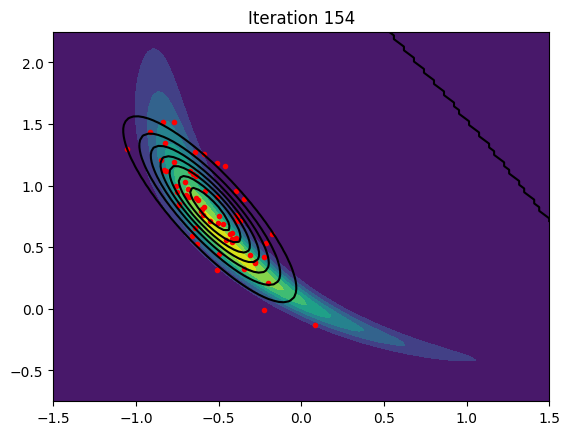

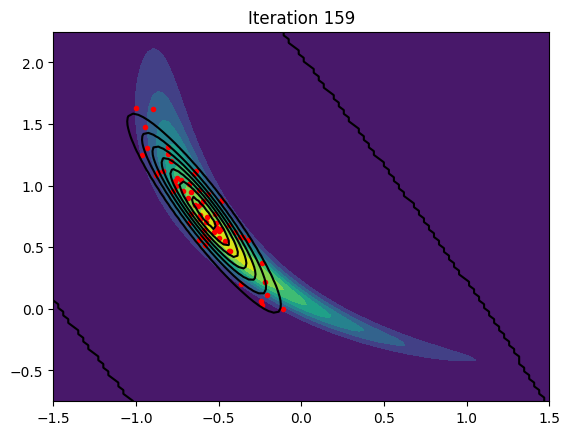

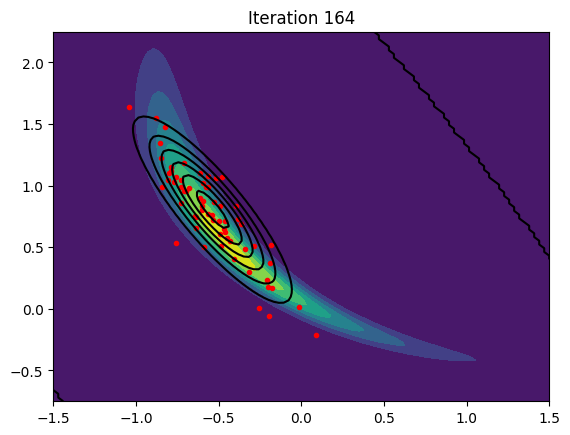

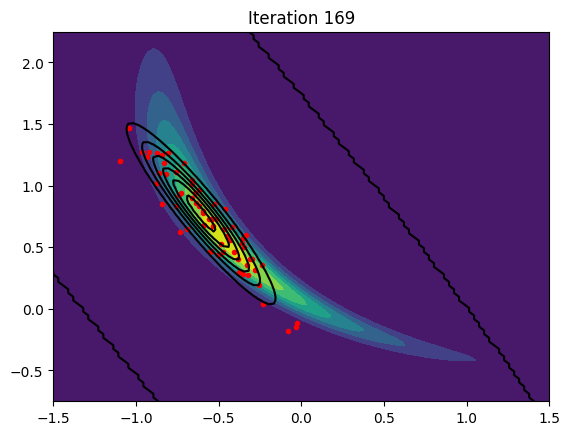

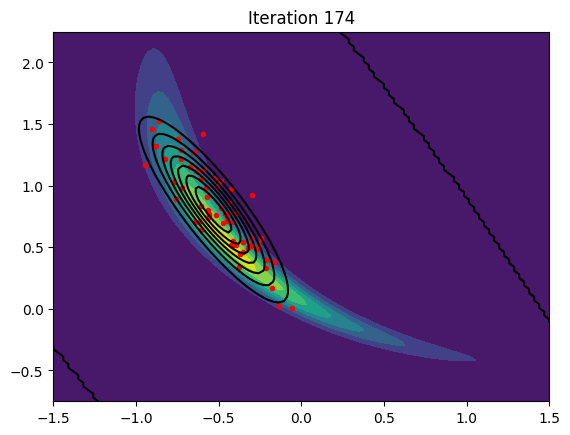

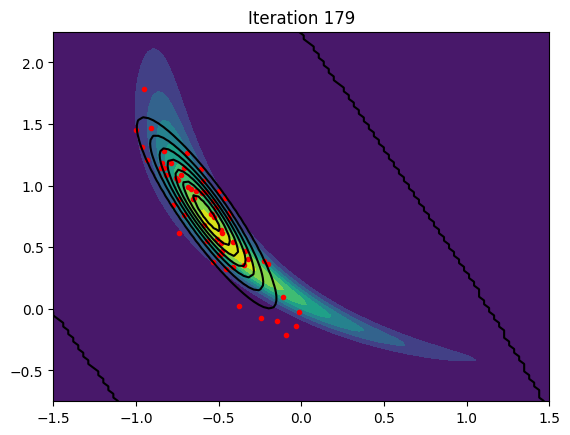

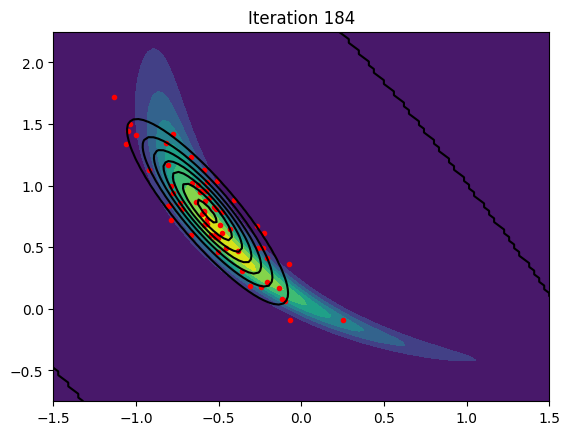

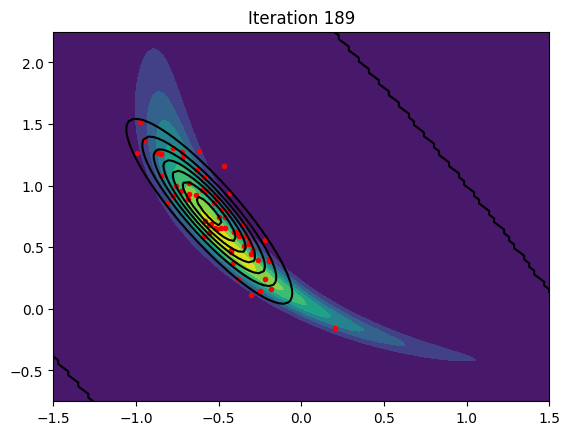

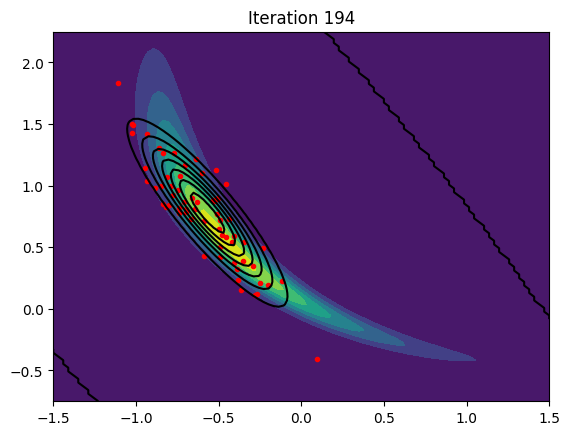

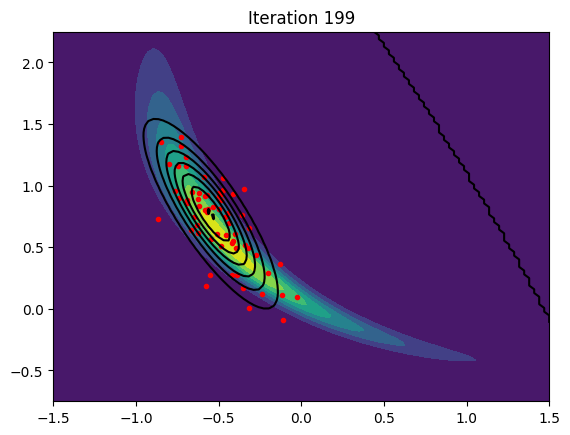

In [90]:
batch_size     = 64         # number of samples at each step
num_steps      = 100        # number of training steps
print_interval = 5          # interval for visualizing intermediate results

# define parameters
pi     = posterior(y=y)
ref    = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
target = MeanFieldGaussianApproximation(pi)
target = FullGaussianApproximation(pi)

# define optimizer
optimizer = torch.optim.Adam(target.parameters(), lr=1e-1)

# define array for negative log-likelihood
his_nll = np.zeros((0,1))

print((2*"%6s   ") % ("step","J_NF"))

train_JML = 0.0
num_step = 0

for step in range(num_steps):

    # evaluate loss function
    x = target.sample(batch_size)
    loss = target.neg_log_prob(x).mean()
    
    # take gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # store loss function
    train_JML += loss.item()
    num_step += 1

    # print loss and plot results
    if (step + 1) % print_interval == 0:
        train_JML /= num_step
        his_nll = np.vstack([his_nll, [train_JML]])
        train_JML = 0.0
        num_step = 0
        
        # evaluate and plot density
        log_px = target.approximate_log_prob(xx).detach()
        xs = target.sample(batch_size,).detach().numpy()
        plt.figure()
        plt.plot(xs[:,0],xs[:,1],'.r')
        plt.contourf(xg[0],xg[1],torch.exp(pi.log_prob(xx).detach().reshape(len(x1), len(x2))))
        plt.contour(xg[0],xg[1],torch.exp(log_px.reshape(len(x1), len(x2))), colors='black')
        plt.xlim(domain_x1)
        plt.ylim(domain_x2)
        plt.title(f'Iteration {step}')
        plt.show()


## Check the final result

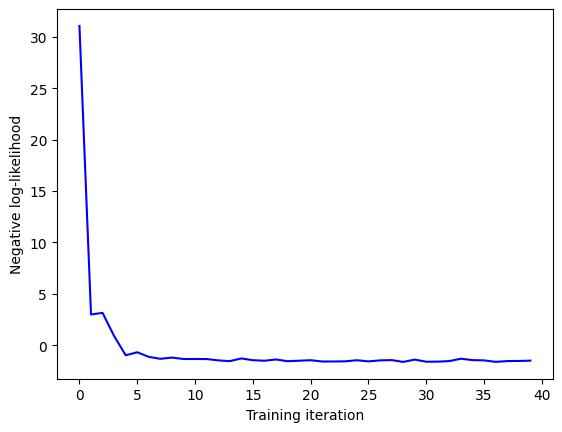

In [91]:
## Check convergence of the objective
plt.figure()
plt.plot(his_nll,'-b')
plt.xlabel('Training iteration')
plt.ylabel('Negative log-likelihood')
plt.show()

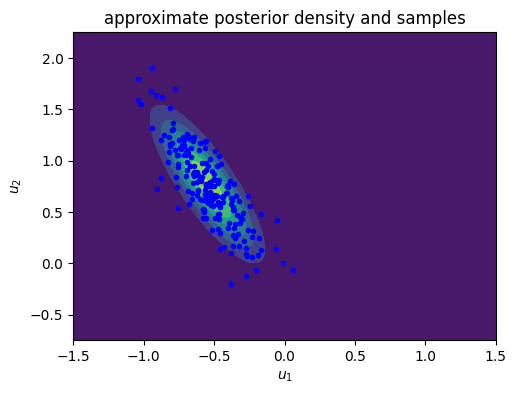

In [92]:
# generate test samples
Ntest = 200

# grid of the spatial domain (for plotting)
x1 = torch.linspace(domain_x1[0],domain_x1[1], 100)
x2 = torch.linspace(domain_x2[0],domain_x2[1], 100)
xg = torch.meshgrid(x1, x2)
xx = torch.cat((xg[0].reshape(-1, 1), xg[1].reshape(-1, 1)), 1)

# evaluate log-probability and sample model
log_px = target.approximate_log_prob(xx).detach()
xs = target.sample(Ntest).detach()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(xg[0],xg[1],torch.exp(log_px.reshape(len(x1), len(x2))))
plt.plot(xs[:,0],xs[:,1],'.b')
plt.title("approximate posterior density and samples")
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.xlim(domain_x1)
plt.ylim(domain_x2)

# grid of the spatial domain (for plotting reference)
domain_z1 = [-4,4]
domain_z2 = [-4,4]
z1 = torch.linspace(domain_z1[0],domain_z1[1], 100)
z2 = torch.linspace(domain_z2[0],domain_z2[1], 100)
zg = torch.meshgrid(z1, z2)
zz = torch.cat((zg[0].reshape(-1, 1), zg[1].reshape(-1, 1)), 1)